In [63]:
%matplotlib inline
import eden
import matplotlib.pyplot as plt
from eden.util import configure_logging
import logging

In [64]:
from itertools import tee, chain, islice
import numpy as np
import random
from time import time
import datetime
from graphlearn.graphlearn import GraphLearnSampler
from eden.util import fit,estimate
from eden.graph import Vectorizer
# get data
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice
def get_graphs(dataset_fname, size=100):
    return  islice(gspan_to_eden(dataset_fname),size)

In [164]:
from scipy.optimize import curve_fit
import numpy as np

def func(x,a,b,c):
    return a * (1 - 1/np.exp(b * x + c))


def plot_data(data_x, full_data, label='', color=None):
    data_y = np.mean(full_data, axis=1)
    ws = 0.02
    cd={'color':color}
    plt.boxplot(full_data, positions=data_x, widths=ws, capprops=cd, medianprops=cd, boxprops=cd, whiskerprops=cd, flierprops=cd)
    plt.plot(data_x,data_y, color=color, linestyle='None', marker='o', markeredgewidth=1, markersize=7, markeredgecolor=color, markerfacecolor='w', label=label)
    try:
        popt,pcov = curve_fit(func, data_x, data_y)
    except:
        pass
    else:
        data_x = np.linspace(data_x[0],data_x[-1],num=100)
        data_y = [func(x,*popt) for x in data_x]
        plt.plot(data_x,data_y, color=color, lw=2)
    
def plot(dataset, percentages, original_sample_repetitions, original_repetitions, sample_repetitions):
    plt.figure(figsize=(18,8))
    plt.grid()   
    
    plot_data(percentages, original_sample_repetitions, label='original+sample', color='g')
    plot_data(percentages, original_repetitions, label='original', color='r')
    plot_data(percentages, sample_repetitions, label='sample', color='b')
    
    plt.xlim(percentages[0]-.05,percentages[-1]+.05)
    plt.title(dataset+'\n',fontsize=17)
    plt.legend(loc='lower right',fontsize=16)
    plt.ylabel('ROC AUC',fontsize=16)
    plt.xlabel('Dataset size (fraction)',fontsize=16)
    plt.savefig('%s_plot_predictive_performance_of_samples.pdf' % dataset)    

In [165]:
def save_results(result_fname,percentages, original_repetitions,original_sample_repetitions,sample_repetitions):
    with open(result_fname,'w') as f:
        f.write('dataset sizes list:\n')
        for perc in percentages:
            f.write('%s '% perc)
        f.write('\n')
        f.write('AUC scores:\n')
        for repetitions in original_repetitions,original_sample_repetitions,sample_repetitions:
            f.write('%s\n' % len(repetitions))
            for repetition in repetitions:
                for auc in repetition:
                    f.write('%s ' % auc)
                f.write('\n')
    
def load_results(result_fname):
    with open(result_fname) as f:
        comment = next(f)
        line = next(f)
        percentages = [float(x) for x in line.split()]
        comment = next(f)

        original_repetitions = []
        size = int(next(f))
        for i in range(size):
            line = next(f)
            repetition = [float(x) for x in line.split()]
            original_repetitions.append(repetition)

        original_sample_repetitions = []
        size = int(next(f))
        for i in range(size):
            line = next(f)
            repetition = [float(x) for x in line.split()]
            original_sample_repetitions.append(repetition)


        sample_repetitions = []
        size = int(next(f))
        for i in range(size):
            line = next(f)
            repetition = [float(x) for x in line.split()]
            sample_repetitions.append(repetition)
            
    return percentages, original_repetitions,original_sample_repetitions,sample_repetitions

In [166]:
import numpy as np
import math

def score(experiment):
    return np.mean([np.mean(repetition) for repetition in experiment])

def scores(result_fname):
    percentages,\
    original_repetitions,\
    original_sample_repetitions,\
    sample_repetitions = load_results(result_fname)
    return  math.log10(score(original_sample_repetitions)/score(original_repetitions))

#Experimental pipeline

In [167]:
#setup
dataset_names = !cat NCI60/names

 0      MALME_3M_t   +0.0031
 1     NCI_H322M_t   -0.0024
 2     SK_MEL_28_t   -0.0053
 3         K_562_t   -0.0057
 4        HCT_15_t   -0.0065
 5      SK_MEL_2_t   -0.0085


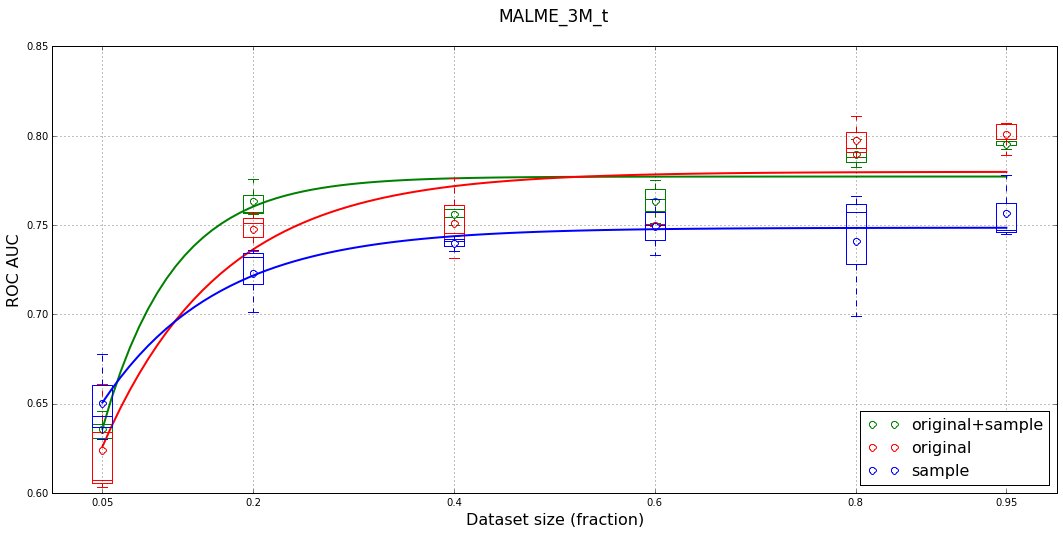

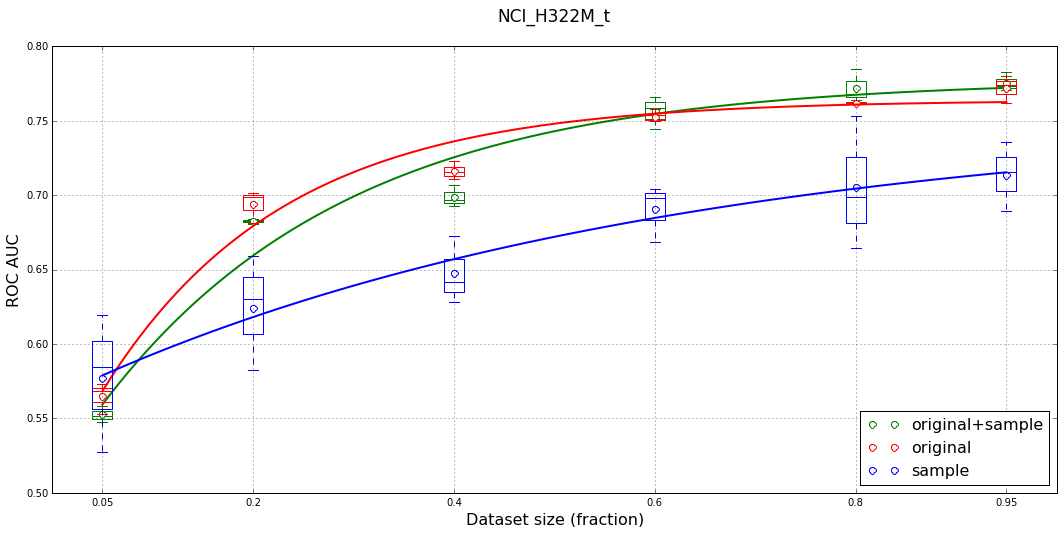

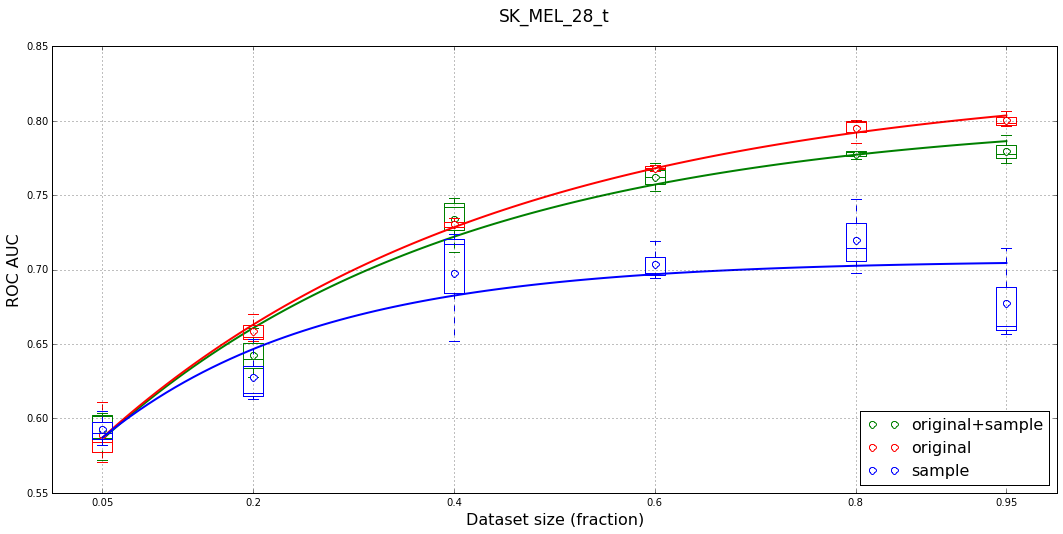

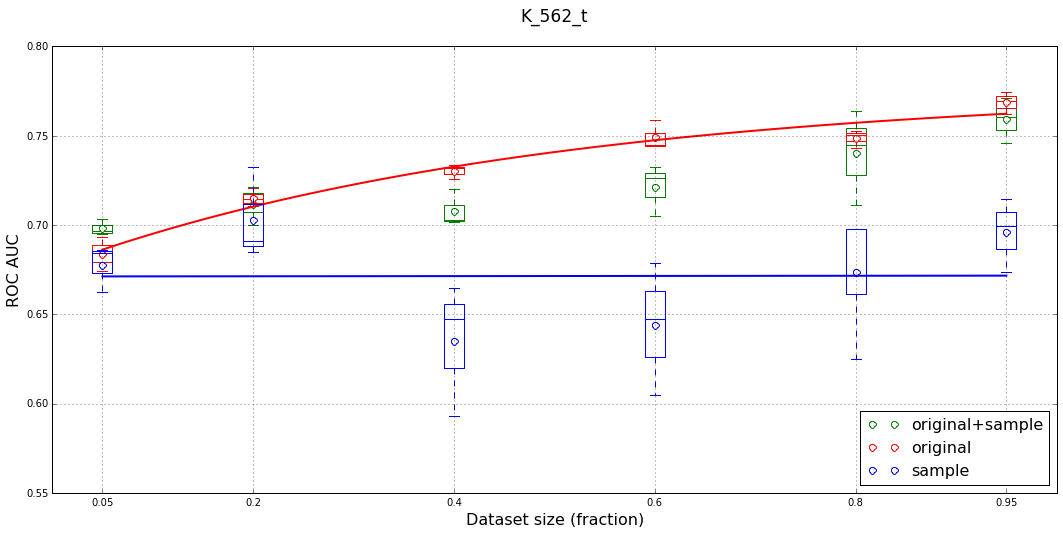

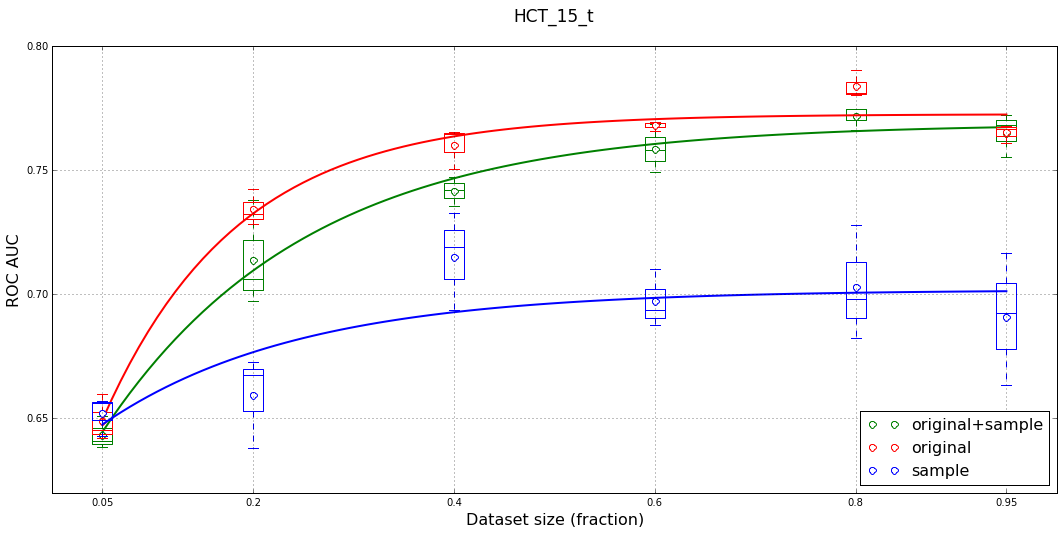

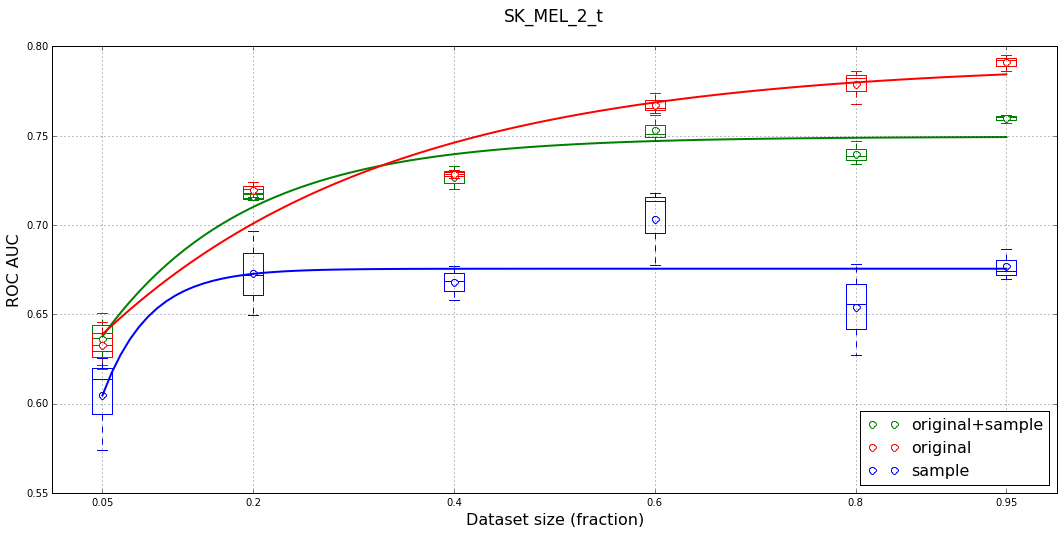

In [168]:
import os.path

performances=[]
for dataset in sorted(dataset_names):
    result_fname='%s_predictive_performance_of_samples.data'%dataset
    if os.path.exists(result_fname):
         performances.append((scores(result_fname),dataset))
            
for i, (score, dataset) in enumerate(sorted(performances, reverse=True)):
    result_fname='%s_predictive_performance_of_samples.data'%dataset
    if os.path.exists(result_fname):
        percentages_l, original_repetitions_l,original_sample_repetitions_l,sample_repetitions_l = load_results(result_fname)
        plot(dataset, percentages_l, original_sample_repetitions_l, original_repetitions_l, sample_repetitions_l)
        print('%2d %15s   %+.4f'%(i, dataset,score))

.